# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

# 1.加载库

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# import spark EDA lib
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum, avg, col, desc, concat, explode, lit, max, min, udf, split
from pyspark.sql import Window

# import spark machine learning lib
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import time lib
from time import time

> 由于项目要求，需要提供github项目地址，但github免费版对上传数据有限制，不能上传大于100MB的文件，需要将原有128MB数据集进行压缩，压缩格式使用bz2，在此格式下，pyspark可以直接读取数据集。

- Mac OS下，通过Terminal使用如下命令将数据集压缩

```
$ bzip2 -z mini_sparkify_event_data.json
```

压缩后数据容量大幅减小，由原来的128MB变为6.4MB

> **注意：使用此命令后会删除被压缩的文件**

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Spark_Sql_Session") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', '63df17717f82'),
 ('spark.driver.port', '46149'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1582389450147'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Sparkify_Spark_Sql_Session'),
 ('spark.ui.showConsoleProgress', 'true')]

# 2.加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json.bz2`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

## 2.1-数据的加载与观察

In [4]:
# 加载数据集
df = spark.read.json('mini_sparkify_event_data.json.bz2')

In [5]:
# 查看数据集描述（方法1）
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# 查看数据集描述（方法2）
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
# 查看第一行数据
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [8]:
# 查看前5行数据
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# 查看部分含义不明确的变量
df.describe('auth', 'itemInSession', 'length', 'method', 'page', 'ts').show()

+-------+----------+------------------+-----------------+------+-------+--------------------+
|summary|      auth|     itemInSession|           length|method|   page|                  ts|
+-------+----------+------------------+-----------------+------+-------+--------------------+
|  count|    286500|            286500|           228108|286500| 286500|              286500|
|   mean|      null|114.41421291448516|249.1171819778458|  null|   null|1.540956889810483...|
| stddev|      null|129.76726201140994|99.23517921058361|  null|   null|1.5075439608226302E9|
|    min| Cancelled|                 0|          0.78322|   GET|  About|       1538352117000|
|    max|Logged Out|              1321|       3024.66567|   PUT|Upgrade|       1543799476000|
+-------+----------+------------------+-----------------+------+-------+--------------------+



In [10]:
df.describe('userAgent').show()

+-------+--------------------+
|summary|           userAgent|
+-------+--------------------+
|  count|              278154|
|   mean|                null|
| stddev|                null|
|    min|"Mozilla/5.0 (Mac...|
|    max|Mozilla/5.0 (comp...|
+-------+--------------------+



**其中auth、method、page、userAgent为分类变量，适合进一步了解其含义。**

In [11]:
df.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



auth变量可能描述的是用户登录状态

In [12]:
df.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



method只有两种变量，get和put，无法理解其具体含义，猜测其与page变量关联较大

In [13]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



page变量描述的内容为用户操作时所在页面

In [14]:
df.select('userAgent').dropDuplicates().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|                null|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



userAgent变量值较多，通过观察，其含义我认为是用户使用Sparkify应用的系统信息，包含操作系统，浏览器版本等内容

In [15]:
# 查看有多少行数据
df.count()

286500

**对变量的理解**  
artist: 歌手  
auth: 登录状态  
firstName: 名  
gender: 性别  
itemInSession:(具体含义暂不明确)  
lastName: 姓氏  
length: 长度(听歌时长)  
level: 会员等级  
location: 地区  
method: 方法(可能与page关联较大)  
page: 请求页面  
registration: 注册时间  
sessionId: 页面ID  
song: 歌曲   
status: 状态  
ts: (具体含义暂不明确)  
userAgent: 用户使用平台信息  
userId: 用户ID

## 2.2-数据清理

In [16]:
# 删除空值
df_dropna = df.dropna(how= 'any', subset = ['userId', 'sessionId'])
# 验证是否还存在空值
df_dropna.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



发现userId变量中还存在空用户，需要继续处理

In [17]:
# 处理userId中的空用户
df_dropna = df_dropna.filter(df_dropna['userId'] != '')
# 验证处理结果
df_dropna.select('userId').dropDuplicates().sort('userId').show(3)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
+------+
only showing top 3 rows



In [18]:
# 查看多少行数据被删除，剩余多少数据
df.count() - df_dropna.count(), df_dropna.count()

(8346, 278154)

# 3.探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 3.1-定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

根据之前对数据集的了解，`Cancellation Confirmation`与`Downgrade`事件为`page`变量中的两项，`Cancellation Confirmation`为**确认注销**，`Downgrade`为**降级**。

In [19]:
# 新建标签，标记page中的Cancellation Confirmation事件，并将转换后的数据改为int型
churn_label = udf(lambda x:1 if x == 'Cancellation Confirmation' else 0, IntegerType())
# 将标记后的数据添加至数据集，列名为churn_temp
df_new = df_dropna.withColumn('churn_temp', churn_label('page'))
# 验证数据
df_new.select('churn_temp').dropDuplicates().show()

+----------+
|churn_temp|
+----------+
|         1|
|         0|
+----------+



虽然标记了**"确认注销"**页面，但同时还要标记与之对应的用户

In [20]:
# 标记userId与churn中的数据对应
group_val = Window.partitionBy('userId')
df_new = df_new.withColumn('churn', max('churn_temp').over(group_val))
# 验证数据
df_new.select('userId', 'churn').dropDuplicates().show(5)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



由于新添加了列，再次查看数据集

In [21]:
df_new.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn_temp: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [22]:
df_new.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn_temp=0, churn=0)

In [23]:
# 与之前数据集的行数对比
df_new.count(), df_dropna.count()

(278154, 278154)

### 3.2-探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

### 3.2.1-删除账户的用户与用户等级的关系

In [24]:
# 提取churn与level特征，整理排序
churn_level_df = df_new.filter('page == "Cancellation Confirmation"') \
    .groupby('level') \
    .count() \
    .toPandas()
# 验证输出
churn_level_df.head(5)

,level,count
0,free,21
1,paid,31


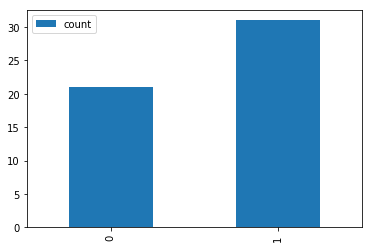

In [25]:
# 使用直方图探索churn与level的关系
churn_level_df.plot.bar();

- 付费用户注销数量比免费用户更多

### 3.2.2-删除账户的用户与性别的关系

In [26]:
# 提取churn与gender特征，整理排序
churn_gender_df = df_new.dropDuplicates(['userId', 'gender']) \
    .groupby(['churn', 'gender']) \
    .count() \
    .sort('churn') \
    .toPandas()
# 验证输出
churn_gender_df.head(5)

,churn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


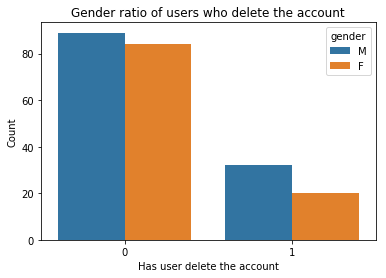

In [27]:
# 通过直方图探索churn与gender的关系
ax = sns.barplot(x = 'churn', y = 'count', hue = 'gender', data = churn_gender_df)
plt.xlabel("Has user delete the account")
plt.ylabel("Count")
plt.title("Gender ratio of users who delete the account");

- 男性用户比女性用户删除账户的人数更多
- 删除账户的比例对一款应用来说比较高
- app可能对男性吸引力更大

# 4.特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

## 4.1-提取特征

### 4.1.1-特征：用户听过的歌手数量

In [28]:
# 汇总每个用户听过的歌手数量
feature_artists = df_new.filter(df_new.page == 'NextSong') \
    .select('userId', 'artist') \
    .dropDuplicates() \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'sum_artist')
# 验证结果
feature_artists.describe().show()

+-------+------------------+-----------------+
|summary|            userId|       sum_artist|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



### 4.1.2-特征：性别

In [29]:
# 将性别改为可计算的数值类型，男性为0，女性为1
feature_gender = df_new.select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
# 验证结果
feature_gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



### 4.1.3-特征：用户听歌时长

In [30]:
# 用户听歌时长
feature_length = df_new.select('userId', 'length') \
    .groupBy('userId') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listening_time')
# 验证结果
feature_length.describe().show()

+-------+------------------+------------------+
|summary|            userId|    listening_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



### 4.1.4-特征：用户所听歌曲总和

In [31]:
# 每个用户所听歌曲的数量
feature_songs = df_new.select('userId', 'song') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'sum_song')
# 验证操作
feature_songs.describe().show()

+-------+------------------+-----------------+
|summary|            userId|         sum_song|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



### 4.1.5-特征：有多少歌曲被加入播放列表

In [32]:
# 被加入播放列表歌曲的数量
feature_ATP = df_new.select('userId', 'page') \
    .where(df_new.page == 'Add to Playlist') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'add_to_play')
# 验证操作
feature_ATP.describe().show()

+-------+------------------+-----------------+
|summary|            userId|      add_to_play|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



### 4.1.6-特征：会员等级

In [33]:
# 将level改为可计算的数值类型，免费为0，付费为1
feature_level = df_new.select('userId', 'level') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'level') \
    .select('userId', col('level').cast('int'))
# 验证结果
feature_level.describe().show()

+-------+------------------+------------------+
|summary|            userId|             level|
+-------+------------------+------------------+
|  count|               360|               360|
|   mean| 64780.23888888889|0.4583333333333333|
| stddev|106080.85223362078|0.4989543383465812|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



逻辑计算后f1分数较低，并且该特征与用户是否删除账户的关系应该不大，该特征暂时不参与计算。

### 4.1.7-标记'churn'

In [34]:
# 获取‘churn'标记
label_churn = df_new.select('userId', col('churn').alias('label')).dropDuplicates()
# 验证操作
label_churn.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



## 4.2-整合所有特征
将以上所有特征整合至一个数据集中

In [35]:
# 整合特征值，准备进行线性代数运算
# 按照userId为索引整合数据时，有部分值缺失，将其用0填充
df_feature = feature_artists.join(feature_gender, 'userId', 'outer') \
    .join(feature_length, 'userId', 'outer') \
    .join(feature_songs, 'userId', 'outer') \
    .join(feature_ATP, 'userId', 'outer') \
    .join(label_churn, 'userId', 'outer') \
    .fillna(0) \
    .drop('userId')

# 查看整合后的数据集
df_feature.show(5)

+----------+------+------------------+--------+-----------+-----+
|sum_artist|gender|    listening_time|sum_song|add_to_play|label|
+----------+------+------------------+--------+-----------+-----+
|       252|     1| 66940.89735000003|     381|          7|    0|
|       339|     0| 94008.87593999993|     474|          8|    0|
|         8|     0|2089.1131000000005|      11|          0|    1|
|      2232|     1|1012312.0927899999|    4825|        118|    0|
|      1385|     0| 523275.8428000004|    2464|         52|    1|
+----------+------+------------------+--------+-----------+-----+
only showing top 5 rows



In [39]:
df_feature.describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|summary|       sum_artist|            gender|    listening_time|         sum_song|       add_to_play|             label|
+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|  count|              225|               225|               225|              225|               225|               225|
|   mean|696.3777777777777|0.4622222222222222|252558.32065155543|          1236.24|29.004444444444445|0.2311111111111111|
| stddev|603.9518698630802|0.4996824388374478| 275396.4038847635|1329.531716432519|32.716653931055426|0.4224832108996327|
|    min|                3|                 0|         691.66884|                6|                 0|                 0|
|    max|             3544|                 1|1991154.9155799907|             9632|               240|                 1|
+-------+---------------

# 5.建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

## 5.1-转换数据

In [40]:
# 将特征工程中的数据集转换为可供模型计算的结构
# level特征暂不参与运算
columns = ['sum_artist', 'gender', 'listening_time', 'sum_song', 'add_to_play']
assembler = VectorAssembler(inputCols = columns, outputCol = 'features_matrix')
data = assembler.transform(df_feature)

In [41]:
# 将模型中的数据变为机器学习时的标准数据范围
scaler = StandardScaler(inputCol = 'features_matrix', outputCol = 'features')
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [42]:
data.describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|summary|       sum_artist|            gender|    listening_time|         sum_song|       add_to_play|             label|
+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|  count|              225|               225|               225|              225|               225|               225|
|   mean|696.3777777777777|0.4622222222222222|252558.32065155543|          1236.24|29.004444444444445|0.2311111111111111|
| stddev|603.9518698630802|0.4996824388374478| 275396.4038847635|1329.531716432519|32.716653931055426|0.4224832108996327|
|    min|                3|                 0|         691.66884|                6|                 0|                 0|
|    max|             3544|                 1|1991154.9155799907|             9632|               240|                 1|
+-------+---------------

In [44]:
# 分割数据集
train, test, validation = data.randomSplit([0.6, 0.2, 0.2])

In [45]:
train.describe().show()

+-------+-----------------+-------------------+------------------+------------------+-----------------+-------------------+
|summary|       sum_artist|             gender|    listening_time|          sum_song|      add_to_play|              label|
+-------+-----------------+-------------------+------------------+------------------+-----------------+-------------------+
|  count|              153|                153|               153|               153|              153|                153|
|   mean|693.9607843137255|0.45751633986928103|  248760.414819281|1217.0522875816994|28.61437908496732|0.20915032679738563|
| stddev|577.5115501505364| 0.4998279717822813|256466.86592151693|  1237.46118381893|30.55821109891538| 0.4080375816547486|
|    min|                3|                  0|         691.66884|                 6|                0|                  0|
|    max|             2904|                  1| 1491493.286370003|              7230|              181|                  1|
+-------

## 5.2-逻辑回归

In [39]:
# 初始化逻辑回归
lr = LogisticRegression(maxIter=5)

# 设置评估标准
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')

# 建立paramGrid
paramGrid = ParamGridBuilder().build()

lr_crossval = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid,
                             evaluator=f1_score)

In [40]:
# 将数据集代入模型计算
# 记录运算时间，时间是衡量算法好坏的一个标准
start = time()
crossval_model = lr_crossval.fit(train)
end = time()
crossval_model.avgMetrics
print("训练集计算用时 {}秒".format(end - start))

训练集计算用时 621.6461043357849秒


In [41]:
# 训练之后，通过验证集查看命中率
lr_result = crossval_model.transform(validation)

In [42]:
# 查看结果
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("逻辑回归分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(lr_result, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(lr_result, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

逻辑回归分数:
准确度: 0.7333333333333333
f1分数: 0.6205128205128204
验证集计算准确度与f1分数用时 166.5191752910614秒


## 5.3-SVM

In [43]:
# 初始化SVM
svm = LinearSVC(maxIter=5)

# 设置评估标准
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')

# 建立paramGrid
paramGrid = ParamGridBuilder().build()

svm_crossval = CrossValidator(estimator=svm,
                              estimatorParamMaps=paramGrid,
                              evaluator=f1_score)

In [44]:
# 将数据集代入模型计算
start = time()
svm_crossval_model = svm_crossval.fit(train)
end = time()
svm_crossval_model.avgMetrics
print("训练集计算用时 {}秒".format(end - start))

训练集计算用时 678.8315546512604秒


In [45]:
# 训练之后，通过验证集查看命中率
svm_result = svm_crossval_model.transform(validation)

In [46]:
# 查看结果
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("SVM分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(svm_result, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(svm_result, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

SVM分数:
准确度: 0.7333333333333333
f1分数: 0.6205128205128204
验证集计算准确度与f1分数用时 164.45260095596313秒


## 5.4-随机森林

In [39]:
# 初始化random forest
rf = RandomForestClassifier()

# 设置评估标准
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')

# 建立paramGrid
paramGrid = ParamGridBuilder().build()

rf_crossval = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid,
                              evaluator=f1_score)

In [40]:
# 将数据集代入模型计算
# 记录运算时间，时间是衡量算法好坏的一个标准
start = time()
rf_crossval_model = rf_crossval.fit(train)
end = time()
rf_crossval_model.avgMetrics
print("训练集计算用时 {}秒".format(end - start))

训练集计算用时 893.3043823242188秒


In [41]:
# 训练之后，通过验证集查看命中率
rf_result = rf_crossval_model.transform(validation)

In [42]:
# 查看结果
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print("随机森林分数:")
start = time()
print("准确度: {}".format(evaluator.evaluate(rf_result, {evaluator.metricName:'accuracy'})))
print("f1分数: {}".format(evaluator.evaluate(rf_result, {evaluator.metricName:'f1'})))
end = time()
print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

随机森林分数:
准确度: 0.8108108108108109
f1分数: 0.7745058491327147
验证集计算准确度与f1分数用时 190.8820571899414秒


## 5.5-计算结果
- 逻辑回归模型的准确度为 0.7333，f1分数为 0.6205，耗时 621秒
- SVM（支持向量机）模型的准确度为 0.7333，f1分数为 0.6205，耗时678秒
- 随机森林模型的准确度为 0.7111，f1分数为 0.6095，耗时 741秒

从计算结果上看逻辑回归和支持向量机的结果相同，但逻辑回归更快。随机森林准确度与f1分数均小于前者，同时也是耗费时间最多的算法。考虑到未来在更大的数据集上计算，时间是一个重要的考虑因素，且逻辑回归与SVM相同，选用逻辑回归算法在完整数据集上运行。

# 6.总结

在特征工程中，开始我将level作为特征，导入逻辑回归模型计算，结果并不理想。去掉level特征后，准确度与f1分数均有10%左右的提升。将逻辑回归算法导入完整数据集计算之前，后续还可以进行其他工作。
- 该结果缺少参考标准。可以计算没有用户删除账户与所有用户删除账户的情况，其分数作为模型选择的参考依据。
- 可以改进算法参数，使其准确率与f1分数更高。
- 还有部分机器学习算法未使用，也许未使用的算法中有更好的结果。

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。